# LANL-Earthquake-Prediction

### Table of Contents
* [1. Introduction](#section1)
* [2. Initial Setup](#section2)
* [3. Training Set](#section3)
* [4. Test Set](#section4)
* [5. Models](#section5)
    * [5.1 Correlations](#section5.1)
    * [5.2 Spectrogram](#section5.2)
    * [5.3 Fourier Transform per Sampling Sequence of 4096 measurements](#section5.3)
    * [5.4 Wavelets Transform per Sampling Sequence of 4096 measurements](#section5.4)
        * [5.4.1. Continous Wavelet Transf](#section5.4.1)
        * [5.4.2. Discrete Wavelet Transform](#section5.4.2)
* [6. Evaluation](#section6)

<a id='section1'></a>
## 1. Introduction

TBD

<a id='section2'></a>
## 2. Initial Setup

In [1]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

import seaborn as sns
sns.set()

from IPython.display import HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import timeit
from tqdm import tqdm

from ipywidgets import interact
import ipywidgets as widgets

from scipy import fftpack

from os import listdir
print(listdir("../input"))

['train.csv', 'train.csv.zip', 'test', 'sample_submission.csv']


<a id='section3'></a>
## 3. Training Set

In [2]:
train_nrows = !wc -l ../input/train.csv
train_nrows_val = int(train_nrows[0].split()[0])
print('train.csv contains {:,} rows'.format(train_nrows_val))

train.csv contains 629,145,481 rows


In [3]:
!head ../input/train.csv

acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744


In [4]:
column_names = !head -n1 ../input/train.csv
print(column_names[0].split(','))

['acoustic_data', 'time_to_failure']


In [5]:
df_train_sample = pd.read_csv('../input/train.csv', skiprows = 0, nrows=100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}) #use chunksize to iterate

In [6]:
def display_df_with_preset_precision(df, precision):
    curr_precision = pd.get_option("display.precision")
    pd.set_option("display.precision", precision)
    display(df)
    pd.set_option("display.precision", curr_precision)
    
display_df_with_preset_precision(df_train_sample.head(), 16)

,acoustic_data,time_to_failure
0,12,1.4690999832000000
1,6,1.4690999821000001
2,8,1.4690999809999998
3,5,1.4690999799000002
4,8,1.4690999787999999


In [7]:
#keep minimal mem footprint 
try:
    del(df_train_sample)    
except NameError:
    pass

In [8]:
start_time = timeit.default_timer()
try:
    del(df_train_iter)    
except NameError:
    pass

df_train_iter = pd.read_csv('../input/train.csv', chunksize=train_nrows_val//100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},iterator=True)

df_after_jumping_up_points = pd.DataFrame()
for df in df_train_iter:
    df['diff_in_time_to_failure']=df['time_to_failure'].diff()
    df_jumps = df.loc[(df['diff_in_time_to_failure'] > 0)]
    #display(df_jumps)
    df_after_jumping_up_points=df_after_jumping_up_points.append(df_jumps)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))    

elapsed time: 118.45 sec


In [9]:
print(df_after_jumping_up_points.shape)
df_after_jumping_up_points

(16, 3)


,acoustic_data,time_to_failure,diff_in_time_to_failure
5656574,4,11.5408,11.540005
50085878,1,14.1806,14.179905
104677356,4,8.8567,8.855905
138772453,-4,12.6940,12.692905
187641820,2,8.0555,8.054905
218652630,4,7.0590,7.057905
245829585,2,16.1074,16.106905
307838917,2,7.9056,7.904905
338276287,3,9.6371,9.636905
375377848,0,11.4264,11.425905


In [10]:
start_time = timeit.default_timer()
try:
    del(df_train_iter)    
except NameError:
    pass

df_train_iter = pd.read_csv('../input/train.csv', chunksize=train_nrows_val//100,
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},iterator=True) #use chunksize to iterate
df_before_jumping_up_points = pd.DataFrame()
for df in df_train_iter:
    if len(df.index.intersection(df_after_jumping_up_points.index-1)) > 0:
        try:
            df_before_jumping_up_points=df_before_jumping_up_points.append(df.loc[df.index.intersection(df_after_jumping_up_points.index-1),:])
        except KeyError:
            print('KeyError')
            pass
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 121.78 sec


In [11]:
print(df_before_jumping_up_points.shape)
df_before_jumping_up_points

(16, 2)


,acoustic_data,time_to_failure
5656573,4,0.000795
50085877,8,0.000695
104677355,6,0.000795
138772452,3,0.001095
187641819,7,0.000595
218652629,5,0.001095
245829584,1,0.000495
307838916,7,0.000695
338276286,4,0.000195
375377847,0,0.000495


In [12]:
start_time = timeit.default_timer()

try:
    del(df_train_tail)    
except NameError:
    pass
df_train_tail = pd.read_csv('../input/train.csv', skiprows = train_nrows_val-100000, iterator=False, names=column_names[0].split(','))
df_train_tail['acoustic_data'] = df_train_tail['acoustic_data'].astype(np.int16)
df_train_tail['time_to_failure'] = df_train_tail['time_to_failure'].astype(np.float64)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 40.45 sec


In [13]:
df_train_tail.tail()

,acoustic_data,time_to_failure
99995,7,9.759796
99996,9,9.759796
99997,10,9.759796
99998,6,9.759796
99999,5,9.759796


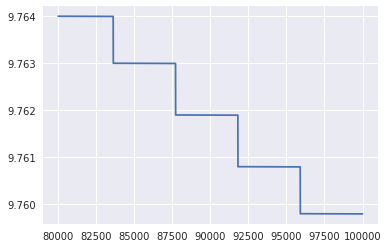

In [14]:
#steps in ttf:
#ttf steps width is 4097 for the last section:
#df_train_tail.tail(4097)['time_to_failure'].plot();
df_train_tail.tail(20000)['time_to_failure'].plot();

In [15]:
start_time = timeit.default_timer()

try:
    del(df_train_head)    
except NameError:
    pass
df_train_head = pd.read_csv('../input/train.csv', skiprows = 0, nrows = 100000, iterator=False)

print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

elapsed time: 0.02 sec


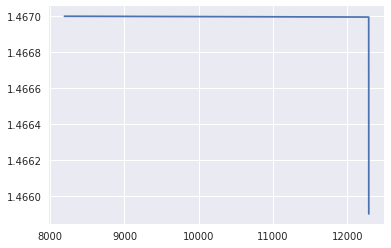

In [16]:
#ttf steps width is 4096 for the first section:
#df_train_head.head(4096)['time_to_failure'].plot();
#df_train_head.head(20000)['time_to_failure'].plot();

df_train_head.head(20000)[8192:8192+4096]['time_to_failure'].plot();

In [17]:
set(df_train_head.head(20000)[8192:8192+4095]['time_to_failure'].diff())

{nan,
 -1.100000313059013e-09,
 -1.100000091014408e-09,
 -1.0999998689698032e-09,
 -1.0999996469251982e-09}

In [18]:
n=0
set(df_train_head.head(2000000)['time_to_failure'].diff())

{nan,
 -0.0010954954999999877,
 -0.0010954954999997657,
 -0.0009954954999999988,
 -0.0009954954999997767,
 -1.100000313059013e-09,
 -1.100000091014408e-09,
 -1.0999998689698032e-09,
 -1.0999996469251982e-09}

What these steps in ttf mean? <br>
Options: 
* 1. we are given not continuos in time sequencies (each 4096 samples) of acustic data. 
* 2. the sequences of the acustic data are continuous in time but ttf represent changing steps/jumps/phases in the state of the material

The first option is more probable as it is unlikely that the changes in the phase states of the material will take place with such ideal periodicity. Then, time/frequency characteristics of the acustic_data should be considered taking into acount that the data is not continous in time. 

We assume that samples of the signal are taken each $10^{-3}$ time units (sec?/usec?) and each sample is a sequence of 4096 measurements taken each $10^{-9}$ time units. So, the length of the entire signal sample is $4.096\times10^{-6}$ time units

In [19]:
index_ranges = [(ent[0],ent[1]) for ent in zip([0]+list(df_after_jumping_up_points.index)[:-1],list(df_before_jumping_up_points.index))]
index_ranges

[(0, 5656573),
 (5656574, 50085877),
 (50085878, 104677355),
 (104677356, 138772452),
 (138772453, 187641819),
 (187641820, 218652629),
 (218652630, 245829584),
 (245829585, 307838916),
 (307838917, 338276286),
 (338276287, 375377847),
 (375377848, 419368879),
 (419368880, 461811622),
 (461811623, 495800224),
 (495800225, 528777114),
 (528777115, 585568143),
 (585568144, 621985672)]

In [20]:
train_set_lengths =np.array([ent[1]-ent[0] for ent in zip([0]+list(df_before_jumping_up_points.index)[:-1],list(df_before_jumping_up_points.index))])
train_set_lengths

array([ 5656573, 44429304, 54591478, 34095097, 48869367, 31010810,
       27176955, 62009332, 30437370, 37101561, 43991032, 42442743,
       33988602, 32976890, 56791029, 36417529])

In [21]:
train_set_lengths.mean()

38874104.5

In [22]:
train_set_lengths.std()

13078782.58174961

In [23]:
range_index = 3 #

RangeIndex(start=0, stop=34095096, step=1)
elapsed time: 15.74 sec


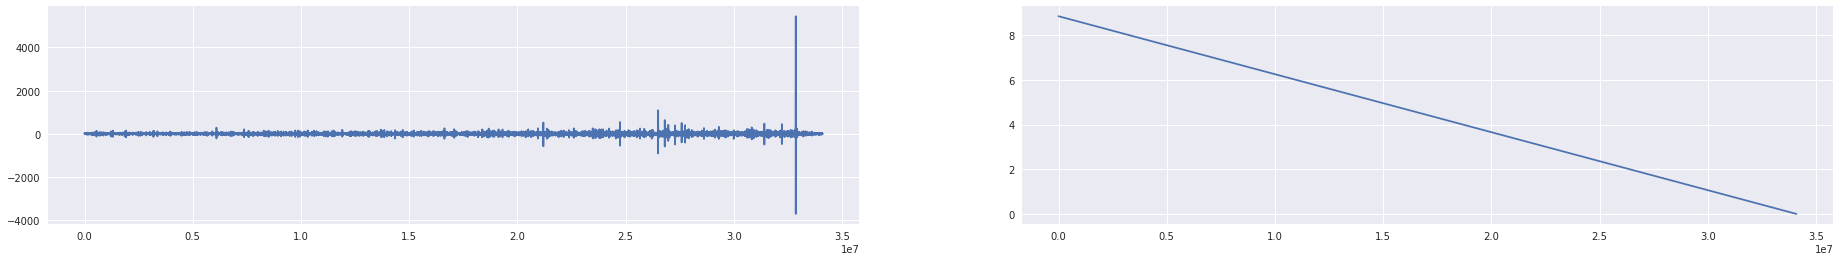

In [24]:
window_size = 15000
window_offset = -window_size
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print(df_sample.index)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
fig.set_size_inches(32,4)
df_sample['acoustic_data'].plot(ax=axs[0]);
#plt.show()
df_sample['time_to_failure'].plot(ax=axs[1]);
#plt.show()
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

We have 16 train sequences. We may use multiple ways to separate them into train and validation groups. This way we will be able to efficiently utilize the training data we have

In [25]:
max_time_to_failure_points = pd.read_csv('../input/train.csv', skiprows = 0, nrows= 1, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})['time_to_failure'].append(df_after_jumping_up_points['time_to_failure'])
max_time_to_failure_points

0             1.4691
5656574      11.5408
50085878     14.1806
104677356     8.8567
138772453    12.6940
187641820     8.0555
218652630     7.0590
245829585    16.1074
307838917     7.9056
338276287     9.6371
375377848    11.4264
419368880    11.0242
461811623     8.8281
495800225     8.5660
528777115    14.7518
585568144     9.4595
621985673    11.6186
Name: time_to_failure, dtype: float64

In [26]:
max_time_to_failure_points.values[:-1]

array([ 1.46909998, 11.54079999, 14.18059999,  8.85669999, 12.69399999,
        8.0555    ,  7.059     , 16.1074    ,  7.9056    ,  9.6371    ,
       11.42640001, 11.02420001,  8.82810001,  8.56600001, 14.75180002,
        9.45950002])

In [27]:
decline_angle_tangents = np.array([ent[0]/ent[1] for ent in zip(max_time_to_failure_points.values[:-1], max_time_to_failure_points.index[1:])])
print(decline_angle_tangents.mean())
print(decline_angle_tangents.std())

6.559536110169193e-08
7.398732224660528e-08


In [28]:
#keep minimal mem footprint 
try:
    del(df_sample)    
except NameError:
    pass

<a id='section4'></a>
## 4. Test Set

In [29]:
test_seg_files = listdir("../input/test")
test_seg_files[:5]

['seg_ba941e.csv',
 'seg_e8d02f.csv',
 'seg_812a50.csv',
 'seg_586726.csv',
 'seg_7fd6b7.csv']

In [30]:
#!ls -l ../input/test | wc -l
len(test_seg_files)

2624

In [31]:
os.path.join("../input/test",test_seg_files[0])

'../input/test/seg_ba941e.csv'

In [32]:
!wc -l {os.path.join("../input/test",test_seg_files[0])}

150001 ../input/test/seg_ba941e.csv


In [33]:
!head {os.path.join("../input/test",test_seg_files[0])}

acoustic_data
6
4
9
10
6
9
7
4
5


In [34]:
def plot_test_seg_by_index(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    df_test_seg['acoustic_data'].plot();

In [35]:
interact(plot_test_seg_by_index, idx=widgets.IntSlider(min=0,max=len(test_seg_files)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idx', max=2623), Output()), _dom_classes=('widget-intera…

In [36]:
#all seg files have the same length: 150,000 samples
seg_files_lengths = !for filename in ../input/test/*; do wc -l $filename; done
{ent.split(' ')[0] for ent in seg_files_lengths}

{'150001'}

<a id='section5'></a>
## 5. Models

Try the following:
* 1. investigate train sequences in parallel with window of variable size:  15000 or smaller
    * 1.1 normalize to the same process development speed; (with_time_to_failure plots)
    * 1.2 present the acustic_data in a form of mean plus delta from mean, then delta from mean present by its mean and delta from its mean etc. 
* 2. remove constant bias in train and in test
* 3. simple MSE alignment 
* 4. simple maximaize dot product
* 5. fourier (fft)
* 6. short-time fourier (time frequency domain)
* 7. wavelets (time frequency domain)
    * 7.1. cwt and dwt
    * 7.2. Haar (rectangular) and Morlet wavelets
* 8. voice spectrogrum; what is we are already given a spectorgrum (or other type of transform) but not the original signal? 
* 9. try to use notebooks used for the detection of gravitation waves
* 10. xgboost
* 11. try to extract a "coherent" signal and to remove the noise in the training data sequences 
* 12. set evaluation criterion
* 13. try to accelerate the process using pytorch (on gpu) for matrix and vector operations
* 14. try Fully Connected NN
* 14. try CNNs on 64 x 64 images based on 4096 samples frames
* 15. try RNNs/LSTMs
* 16. try exponential or other smoothing to reduce noise 
* 17. try considering 4096 samples as 64 x 64 image
* 18. try averaging over all 16 training sequences - (in time or frequencey space)

<a id='section5.1'></a>
### 5.1. Correlations

time_to_failure decline rate = 0.0000002597155527
elapsed time: 1.58 sec


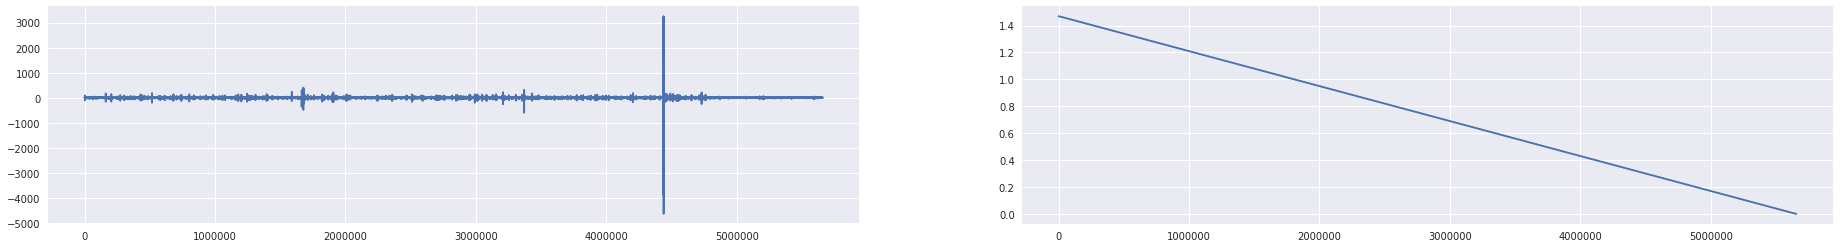

In [37]:
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass

range_index=0 #first training sequence is the shortest one
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)
fig.set_size_inches(32,4)
df_sample['acoustic_data'].plot(ax=axs[0]);
#plt.show()
print ('time_to_failure decline rate = {:.16f}'.format(df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]))
df_sample['time_to_failure'].plot(ax=axs[1]);
#plt.show()
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

In [38]:
df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]

2.5971555272070207e-07

In [39]:
df_sample['time_to_failure'].shape[0]

5656573

we need to find points of maximum cross-correlation between the segment and the training sequence<br>
To save time, the correlation should be calculated efficiently - this means do not implement it by yourself in python. We need to find best implementation of the correlation function. 

In [40]:
df_sample['acoustic_data'].head()

0    12
1     6
2     8
3     5
4     8
Name: acoustic_data, dtype: int16

In [41]:
df_sample['acoustic_data'].mean()

4.560983125295121

In [42]:
train_values = (df_sample['acoustic_data']-df_sample['acoustic_data'].mean()).values
train_values

array([ 7.43901687,  1.43901687,  3.43901687, ..., -2.56098313,
       -0.56098313,  0.43901687])

In [43]:
df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[0]), dtype={'acoustic_data': np.int16})
df_test_seg.head()

,acoustic_data
0,6
1,4
2,9
3,10
4,6


In [44]:
df_test_seg['acoustic_data'].mean()

4.14376

In [45]:
test_values = (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).values

In [46]:
from scipy import signal

In [47]:
train_values.shape

(5656573,)

In [48]:
test_values.shape

(150000,)

In [49]:
signal_corr = signal.correlate(np.square(train_values), np.square(test_values),mode='valid', #full, valid, same
                               method='fft')

In [50]:
signal_corr.shape

(5506574,)

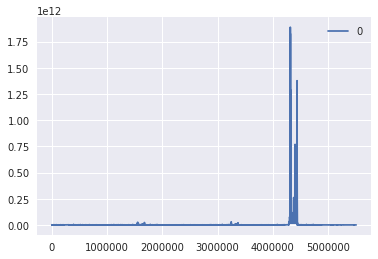

In [51]:
pd.DataFrame(signal_corr).plot();

In [52]:
def correlation_with_test_seg_idx(idx):
    df_test_seg = pd.read_csv(os.path.join("../input/test",test_seg_files[idx]), dtype={'acoustic_data': np.int16})
    test_values = (df_test_seg['acoustic_data']-df_test_seg['acoustic_data'].mean()).values
    signal_corr = signal.correlate(np.square(train_values), np.square(test_values),mode='same', method='fft')
    pd.DataFrame(signal_corr).plot();

In [53]:
interact(correlation_with_test_seg_idx, idx=widgets.IntSlider(min=0,max=len(test_seg_files)-1,step=1,value=0));

interactive(children=(IntSlider(value=0, description='idx', max=2623), Output()), _dom_classes=('widget-intera…

In [54]:
#start_time = timeit.default_timer()
#np_corr = np.correlate(df_sample['acoustic_data'].values, df_test_seg['acoustic_data'].values)
#print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))    
#this takes too long

<a id='section5.2'></a>
### 5.2 Spectrogram

In [55]:
from scipy.signal import spectrogram

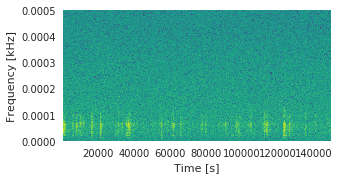

In [56]:
M = 1024
N = 1024
freqs, times, Sx = signal.spectrogram(df_test_seg['acoustic_data'].values, fs=1, window='hanning',
                                      nperseg=N, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(4.8, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

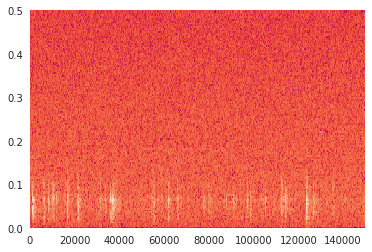

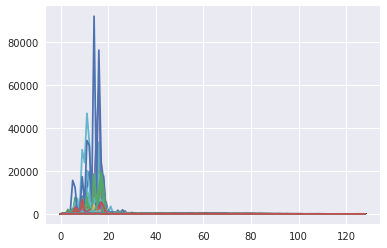

In [57]:
f, t, Sxx = spectrogram(df_test_seg['acoustic_data'].values)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.show()
plt.plot(Sxx)
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
plt.show()

In [58]:
from skimage import util

M = 1024

slices = util.view_as_windows(df_test_seg['acoustic_data'].values, window_shape=(M,), step=100)
print(f'data shape: {df_test_seg["acoustic_data"].values.shape}, Sliced data shape: {slices.shape}')

data shape: (150000,), Sliced data shape: (1490, 1024)


In [59]:
win = np.hanning(M + 1)[:-1]
slices = slices * win

In [60]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

Shape of `slices`: (1024, 1490)


In [61]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

In [62]:
L=df_test_seg['acoustic_data'].values.shape[0]

In [63]:
rate=10

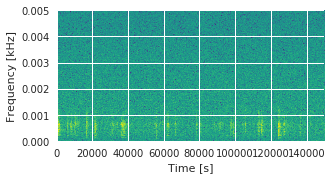

In [64]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

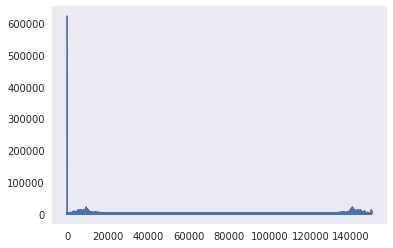

In [65]:
#df_test_seg['acoustic_data'].values
# Number of sample points
#N = 600
# sample spacing
#T = 1.0 / 800.0
#x = np.linspace(0.0, N*T, N)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

#yf = fft(y)
yf = fftpack.fft(df_test_seg['acoustic_data'].values)
#df_test_seg['acoustic_data'].values

#xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.plot(np.abs(yf))
plt.grid()
plt.show()

<a id='section5.3'></a>
## 5.3 Fourier Transform per Sampling Sequence of 4096 measurements

https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html <br>
https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html

In [66]:
range_index=12 #first training sequence is the shortest one
sequence_length = 4096
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print(df_sample.shape[0]/sequence_length)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

8297.998291015625
elapsed time: 36.36 sec


In [67]:
#MEAN (Bias) is removed 
#sequence_idx = 2 #10845
avg_len=2
sequence_offset = 0
def show_frame_and_fft(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=6, sharex=False)

    print(df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length].shape)
    df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['time_to_failure'].plot(ax=axs[0]);
    
    acustic_data_series = df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data']
    (acustic_data_series - acustic_data_series.mean()).plot(ax=axs[1]);
    #df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data'].plot(ax=axs[1]);

    fig.set_size_inches(32,4)
    
    acustic_data_ft = fftpack.fft(acustic_data_series-acustic_data_series.mean())
    freqs = fftpack.fftfreq(len(acustic_data_ft))
    pd.DataFrame.from_dict({'acustic_data_ft_amp': np.abs(acustic_data_ft), 'freqs':freqs}).set_index('freqs').plot(ax=axs[2])

    #pd.DataFrame.from_dict({'acustic_data_ft_angle': np.angle(acustic_data_ft), 'freqs':freqs}).set_index('freqs').plot(ax=axs[3])
    #pd.DataFrame.from_dict({'acustic_data_ft_angle': np.angle(acustic_data_ft)[1:]+np.angle(acustic_data_ft)[:len(acustic_data_ft)-1], 'freqs':freqs[1:]}).set_index('freqs').plot(ax=axs[3])
    pd.DataFrame.from_dict({'acustic_data_ft_angle': np.angle(acustic_data_ft), 'freqs':freqs}).set_index('freqs').rolling(avg_len).mean().plot(ax=axs[3])

    pd.DataFrame.from_dict({'acustic_data_ft_real': np.real(acustic_data_ft), 'freqs':freqs}).set_index('freqs').plot(ax=axs[4])

    pd.DataFrame.from_dict({'acustic_data_ft_img': np.imag(acustic_data_ft), 'freqs':freqs}).set_index('freqs').plot(ax=axs[5])

    #axs[2].stem(freqs, np.abs(acustic_data_ft))
    len(acustic_data_ft)
    #print ('time_to_failure decline rate = {:.16f}'.format(df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]))

In [68]:
interact(show_frame_and_fft, sequence_idx=widgets.IntSlider(min=0,max=df_sample.shape[0]/sequence_length,step=1,value=0));

interactive(children=(IntSlider(value=0, description='sequence_idx', max=8297), Output()), _dom_classes=('widg…

<a id='section5.4'></a>
## 5.4 Wavelets Transform per Sampling Sequence of 4096 measurements

In [69]:
range_index=12 #first training sequence is the shortest one
sequence_length = 4096
start_time = timeit.default_timer()
try:
    del(df_sample)    
except NameError:
    pass
df_sample = pd.read_csv('../input/train.csv', skiprows = index_ranges[range_index][0], nrows= index_ranges[range_index][1]-index_ranges[range_index][0],
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_sample.columns=['acoustic_data','time_to_failure']
print(df_sample.shape[0]/sequence_length)
print('elapsed time: {:.2f} sec'.format(timeit.default_timer()-start_time))

8297.998291015625
elapsed time: 35.74 sec


https://github.com/fbcotter/pytorch_wavelets

[Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks with Octave Convolution](https://arxiv.org/abs/1904.05049)

In [70]:
#from scipy.signal import cwt
from scipy import signal



<a id='section5.4.1'></a>
### 5.4.1. Continous Wavelet Transform

In [71]:
#MEAN (Bias) is removed 
#sequence_idx = 2 #10845
avg_len=2
sequence_offset = 0
def show_frame_and_cwt(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False)

    print(df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length].shape)
    df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['time_to_failure'].plot(ax=axs[0]);
    
    acustic_data_series = df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data']
    acustic_data_series_zero_mean = (acustic_data_series - acustic_data_series.mean())
    acustic_data_series_zero_mean.plot(ax=axs[1])
    #df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data'].plot(ax=axs[1]);

    fig.set_size_inches(32,4)
    
    acustic_data_cwt = signal.cwt(acustic_data_series_zero_mean, signal.morlet, #signal.morlet, signal.ricker
                                  np.arange(1,31))
    axs[2].imshow(acustic_data_cwt, #extent=[-1,1,31,1], 
                  cmap='PRGn', aspect='auto',  #vmax=abs(acustic_data_series_zero_mean).max(), vmin=-abs(acustic_data_series_zero_mean).max()
                 )
    #axs[2].stem(freqs, np.abs(acustic_data_ft))
    print(len(acustic_data_cwt))
    #print ('time_to_failure decline rate = {:.16f}'.format(df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]))
    print(acustic_data_cwt.shape)

In [72]:
interact(show_frame_and_cwt, sequence_idx=widgets.IntSlider(min=0,max=df_sample.shape[0]/sequence_length,step=1,value=0));

interactive(children=(IntSlider(value=0, description='sequence_idx', max=8297), Output()), _dom_classes=('widg…

<a id='section5.4.2'></a>
### 5.4.2. Discrete Wavelet Transform

Denoise and compress the signal

multilevel wavelet decomposition

In [73]:
from pywt import wavedec

In [74]:
#MEAN (Bias) is removed 
#sequence_idx = 2 #10845
avg_len=2
sequence_offset = 0
def show_frame_and_dwt(sequence_idx):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False)

    print(df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length].shape)
    df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['time_to_failure'].plot(ax=axs[0]);
    
    acustic_data_series = df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data']
    acustic_data_series_zero_mean = (acustic_data_series - acustic_data_series.mean())
    acustic_data_series_zero_mean.plot(ax=axs[1])
    #df_sample[sequence_offset+sequence_length*sequence_idx:sequence_offset+sequence_length*sequence_idx+sequence_length]['acoustic_data'].plot(ax=axs[1]);

    fig.set_size_inches(32,4)
    
    acustic_data_dwt_coeffs = wavedec(acustic_data_series_zero_mean,'db1', level=1)
    #acustic_data_cwt = signal.cwt(acustic_data_series_zero_mean, signal.morlet, #signal.morlet, signal.ricker
    #                              np.arange(1,31))
    #axs[2].imshow(acustic_data_cwt, #extent=[-1,1,31,1], 
    #              cmap='PRGn', aspect='auto',  #vmax=abs(acustic_data_series_zero_mean).max(), vmin=-abs(acustic_data_series_zero_mean).max()
    #             )
    #axs[2].stem(freqs, np.abs(acustic_data_ft))
    print(len(acustic_data_dwt_coeffs))
    print((acustic_data_dwt_coeffs[0]).shape)
    #print ('time_to_failure decline rate = {:.16f}'.format(df_sample['time_to_failure'][0]/df_sample['time_to_failure'].shape[0]))
    print(acustic_data_dwt_coeffs)

In [75]:
interact(show_frame_and_dwt, sequence_idx=widgets.IntSlider(min=0,max=df_sample.shape[0]/sequence_length,step=1,value=0));

interactive(children=(IntSlider(value=0, description='sequence_idx', max=8297), Output()), _dom_classes=('widg…

<a id='section6'></a>
## Evaluation

given the test segment length 150000 samples, what is the required time precision?